# Magnitude at 5 Sigma from background

In [27]:
# Check the version of MAF - the output should be version 2.4.2 or higher.
# 'unknown' means you're running from a git repo version,
# and have made changes to your local code

import lsst.sims.maf
lsst.sims.maf.__version__

'2.13.0.sims-59-g0a27faef'

In [28]:
# import matplotlib to show plots inline.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [29]:
# import our python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

from lsst.sims.maf.db import ResultsDb

In [30]:
import sys
print(sys.path)

['/Users/dagoret/MacOSX/GitHub/LSST/MyCadence/SkyBrightness', '/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/obs_lsst/19.0.0-80-g0bd2bb3+1/python', '/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/ts_dateloc/master-g60a36c8d46+46/python', '/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/ts_observatory_model/master-g3d307a5f45+46/python', '/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_almanac/master-g021b69e146+1/python', '/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_downtimeModel/master-g55f72efa65+17/python', '/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_cloudModel/master-ge3724df529+19/python', '/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sim

### Specify my other python path (my installation)

In [31]:
otherpythonpaths=['/Users/dagoret/anaconda3/lib/python37.zip', '/Users/dagoret/anaconda3/lib/python3.7', '/Users/dagoret/anaconda3/lib/python3.7/lib-dynload', '', '/Users/dagoret/.local/lib/python3.7/site-packages', '/Users/dagoret/anaconda3/lib/python3.7/site-packages', '/Users/dagoret/anaconda3/lib/python3.7/site-packages/aeosa', '/Users/dagoret/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/Users/dagoret/.ipython']

In [32]:
for thepath in otherpythonpaths:
    sys.path.append(thepath) # go to parent dir

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Config

In [34]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
colors = {'u': 'cyan', 'g': 'g', 'r': 'y','i': 'r', 'z': 'm', 'y': 'k'}
Nfilt=len(filters)

In [36]:
nyears=1.0
maxnights=365.25*nyears

In [37]:
all_sqlconstraint=[]
all_bundlename1=[]
all_bundlename2=[]
for f in filters:
    sqlconstraint = 'filter = \"{}\" and night< {}'.format(f,maxnights)
    bundlename1    = 'bund1SBN_{}'.format(f) 
    bundlename2    = 'bund2SBN_{}'.format(f) 
    all_sqlconstraint.append(sqlconstraint)
    all_bundlename1.append(bundlename1)
    all_bundlename2.append(bundlename2)

In [38]:
all_sqlconstraint

['filter = "u" and night< 365.25',
 'filter = "g" and night< 365.25',
 'filter = "r" and night< 365.25',
 'filter = "i" and night< 365.25',
 'filter = "z" and night< 365.25',
 'filter = "y" and night< 365.25']

In [39]:
all_bundlename1

['bund1SBN_u',
 'bund1SBN_g',
 'bund1SBN_r',
 'bund1SBN_i',
 'bund1SBN_z',
 'bund1SBN_y']

In [40]:
all_bundlename2

['bund2SBN_u',
 'bund2SBN_g',
 'bund2SBN_r',
 'bund2SBN_i',
 'bund2SBN_z',
 'bund2SBN_y']

# Simu data

In [41]:
# Note the V3 for opening opsim version 3.x databases.
# Use V4 for more recent runs.

#opsdb = db.OpsimDatabase('baseline2018a.db')
opsdb = db.OpsimDatabase('/Users/dagoret/DATA/Cadence/baseline2018a.db')
outDir = 'output_skybrightnessandm5sigma'
resultsDb = db.ResultsDb(outDir=outDir)

# Metrics

In [42]:
# metric = the "maximum" of the "skybrightness" for each group of visits in the slicer
metric1 = metrics.MeanMetric('skyBrightness')
metric2 = metrics.MeanMetric('fiveSigmaDepth')

summaryMetrics = [metrics.MinMetric(), metrics.MedianMetric(),
                  metrics.MaxMetric(), metrics.RmsMetric()]


# slicer = a grouping or subdivision of visits for the simulated survey
# based on their position on the sky (using a Healpix grid)
#slicer1 = slicers.OneDSlicer(sliceColName='night', binsize=10)
slicer = slicers.OneDSlicer(sliceColName='night', binsize=1, binMin=0, binMax=365*10)


# Bundle

- Bundles dict for all filter

In [43]:
bundles = {}
for ifilt in np.arange(Nfilt):
    sqlconstraint = all_sqlconstraint[ifilt]
    bundlename1    = all_bundlename1[ifilt]
    bundlename2    = all_bundlename2[ifilt]
    bundles[bundlename1] = metricBundles.MetricBundle(metric1, slicer, sqlconstraint,summaryMetrics=summaryMetrics)
    bundles[bundlename2] = metricBundles.MetricBundle(metric2, slicer, sqlconstraint,summaryMetrics=summaryMetrics)
    
    
    print(bundles[bundlename1].dbCols)
    print(bundles[bundlename2].dbCols)

{'night', 'skyBrightness'}
{'fiveSigmaDepth', 'night'}
{'night', 'skyBrightness'}
{'fiveSigmaDepth', 'night'}
{'night', 'skyBrightness'}
{'fiveSigmaDepth', 'night'}
{'night', 'skyBrightness'}
{'fiveSigmaDepth', 'night'}
{'night', 'skyBrightness'}
{'fiveSigmaDepth', 'night'}
{'night', 'skyBrightness'}
{'fiveSigmaDepth', 'night'}


In [44]:
bgroup = metricBundles.MetricBundleGroup(bundles, opsdb, outDir=outDir, 
                                         resultsDb=resultsDb)

Querying database SummaryAllProps with constraint filter = "z" and night< 365.25 for columns ['fiveSigmaDepth', 'skyBrightness', 'night']
Found 69410 visits
Running:  ['bund1SBN_z', 'bund2SBN_z']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "g" and night< 365.25 for columns ['fiveSigmaDepth', 'skyBrightness', 'night']
Found 16330 visits
Running:  ['bund1SBN_g', 'bund2SBN_g']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "y" and night< 365.25 for columns ['fiveSigmaDepth', 'skyBrightness', 'night']


/cvmfs/sw.lsst.eu/darwin-x86_64/lsst_sims/sims_w_2020_31/stack/miniconda3-py37_4.8.2-1a1d771/DarwinX86/sims_maf/2.13.0.sims-59-g0a27faef/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 1.000000 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Found 57904 visits
Running:  ['bund1SBN_y', 'bund2SBN_y']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "i" and night< 365.25 for columns ['fiveSigmaDepth', 'skyBrightness', 'night']
Found 30745 visits
Running:  ['bund1SBN_i', 'bund2SBN_i']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "u" and night< 365.25 for columns ['fiveSigmaDepth', 'skyBrightness', 'night']
Found 14623 visits
Running:  ['bund1SBN_u', 'bund2SBN_u']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "r" and night< 365.25 for columns ['fiveSigmaDepth', 'skyBrightness', 'night']
Found 39324 visits
Running:  ['bund1SBN_r', 'bund2SBN_r']
Completed metric generation.
Running reduce methods.
Running summary statistic

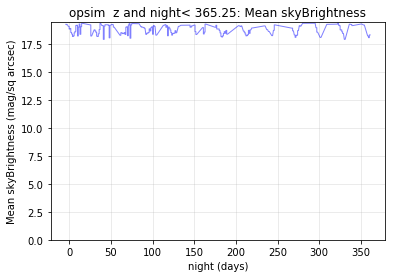

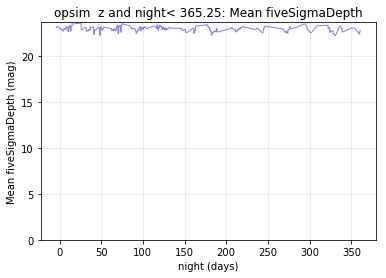

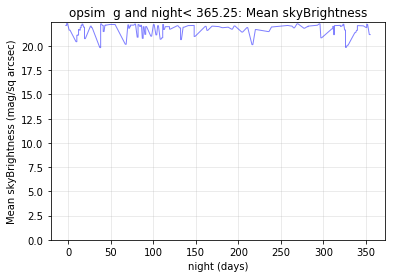

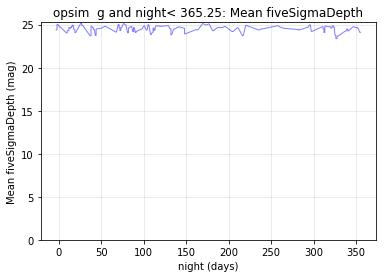

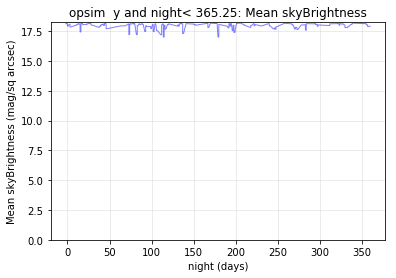

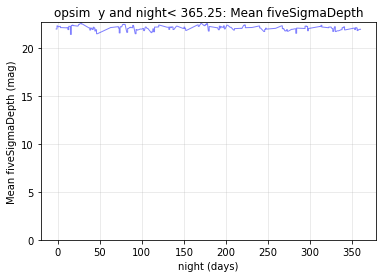

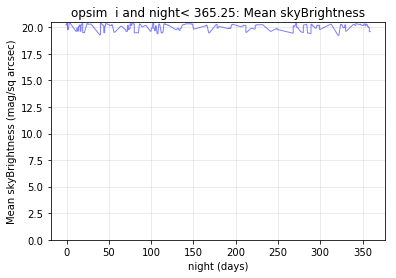

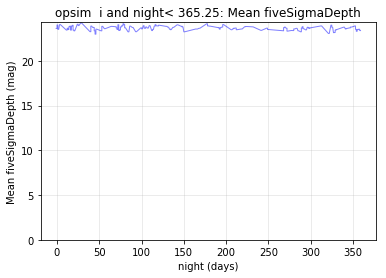

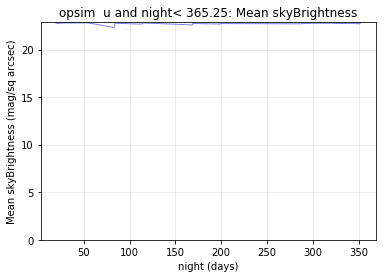

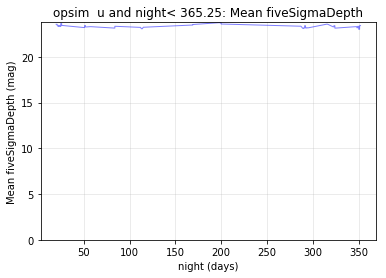

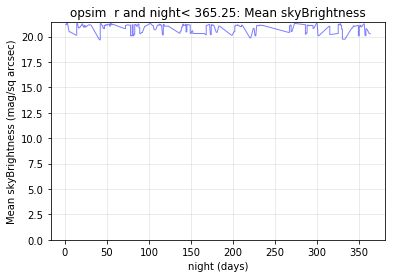

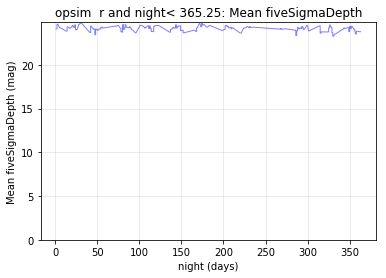

In [45]:
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [46]:
for ifilt in np.arange(Nfilt):
    
    bundlename1    = all_bundlename1[ifilt]

    print("===============================",filters[ifilt],"===============================")
    print(bundles[bundlename1].dbCols)
    print(len(bundles[bundlename1].metricValues))
    print(bundles[bundlename1].metricValues[0:50])
    print(bundles[bundlename1].summaryValues)
    

=============================== u ===============================
{'night', 'skyBrightness'}
3660
[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- 22.762751663868325 22.782665775135417 22.764312494202475
 22.7631825290572 22.795659364202606 22.776560797401448 22.78816650788193
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --]
{'Min': 22.319328273907487, 'Median': 22.751585848433606, 'Max': 22.828660859190787, 'Rms': 0.0817109157805309}
=============================== g ===============================
{'night', 'skyBrightness'}
3654
[-- -- -- 22.127234389721522 22.32046052009684 -- -- 21.63873426888712 --
 -- -- -- -- -- -- 20.44932788203679 21.110416579919466 21.1411140430891
 21.70514108588066 21.648055043740026 21.902558606520554 22.11857733992723
 22.264322104765256 -- 21.948164853099996 20.7652320007061 -- -- -- -- --
 -- 22.051957731896994 21.90404951126376 -- -- -- -- -- -- -- -- --
 19.839737449628938 22.28498767365911 -- 22.124615229317527
 21.

In [47]:
for ifilt in np.arange(Nfilt):
    
    bundlename2    = all_bundlename2[ifilt]

    print("===============================",filters[ifilt],"===============================")
    print(bundles[bundlename2].dbCols)
    print(len(bundles[bundlename2].metricValues))
    print(bundles[bundlename2].metricValues[0:50])
    print(bundles[bundlename2].summaryValues)
    

=============================== u ===============================
{'fiveSigmaDepth', 'night'}
3660
[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- 23.56914748936922 23.460240528448516 23.334532602455937
 23.428515799597896 23.33245869700431 23.64835852080586 23.439315038805756
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --]
{'Min': 23.02720361096488, 'Median': 23.334532602455937, 'Max': 23.74502254711423, 'Rms': 0.17556238982001865}
=============================== g ===============================
{'fiveSigmaDepth', 'night'}
3654
[-- -- -- 24.391281852345436 25.02061758137099 -- -- 24.71413834548461 --
 -- -- -- -- -- -- 24.032689097050838 24.302264002138173
 24.312569847637025 24.650788383561167 24.60201783742074
 24.648842177289445 24.80133834998915 24.934820858443356 --
 24.403837819115736 24.08554066818566 -- -- -- -- -- -- 25.173905336380223
 24.923886405425833 -- -- -- -- -- -- -- -- -- 23.697908149764494
 24.805418331794474 -- 24.621119475328

Text(0.5, 1.0, 'Magnitude 5sigma')

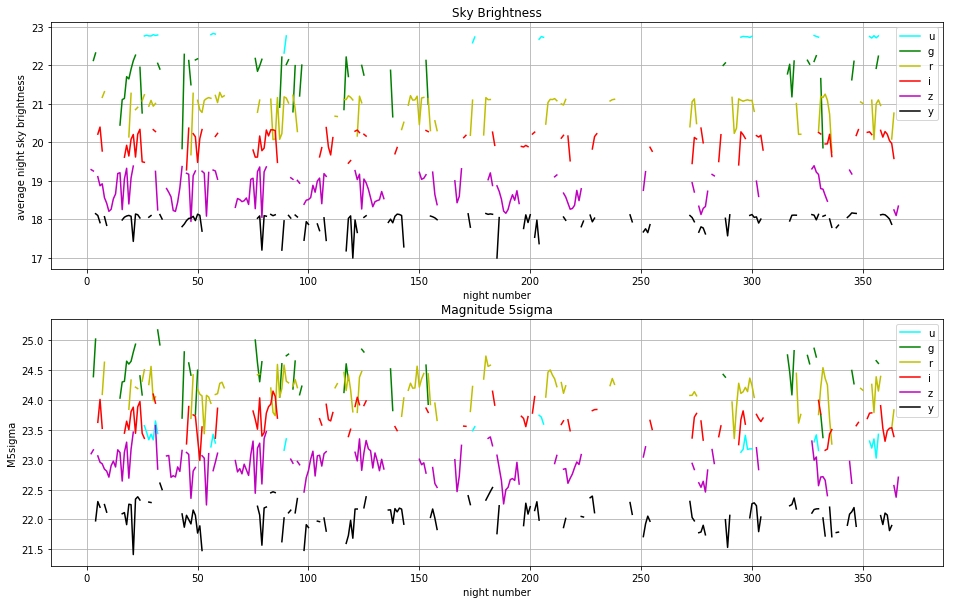

In [48]:
fig=plt.figure(figsize=(16,10))
ax1=fig.add_subplot(211)
for ifilt in np.arange(Nfilt):
    
    bundlename1 = all_bundlename1[ifilt]
    #plt.plot(bundles[bundlename].metricValues,'-',color=colors[ifilt],label=filters[ifilt])
    ax1.plot(bundles[bundlename1].metricValues,'-',color=colors[filters[ifilt]] ,label=filters[ifilt])
    
ax1.legend()
ax1.set_title("Sky Brightness")
ax1.grid()
ax1.set_xlabel("night number")
ax1.set_ylabel("average night sky brightness")

ax2=fig.add_subplot(212)
for ifilt in np.arange(Nfilt):
    
    bundlename2 = all_bundlename2[ifilt]
    #plt.plot(bundles[bundlename].metricValues,'-',color=colors[ifilt],label=filters[ifilt])
    ax2.plot(bundles[bundlename2].metricValues,'-',color=colors[filters[ifilt]] ,label=filters[ifilt])
    
ax2.legend()
ax2.grid()
ax2.set_xlabel("night number")
ax2.set_ylabel("M5sigma")
ax2.set_title("Magnitude 5sigma")
    

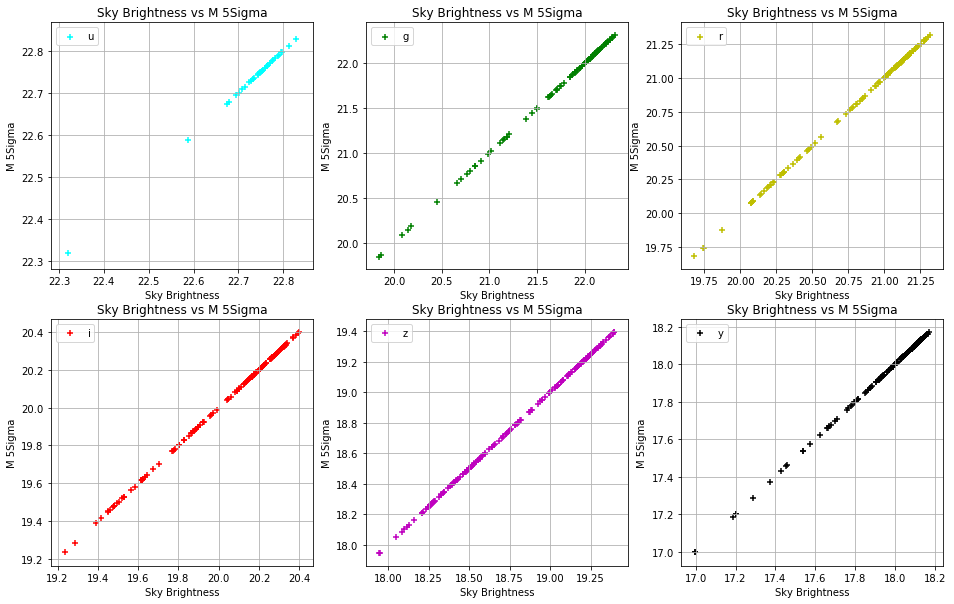

In [49]:
fig=plt.figure(figsize=(16,10))

isubplot=[231,232,233,234,235,236]
ifilt=0

for ifilt in np.arange(Nfilt):
    ax=fig.add_subplot(isubplot[ifilt])
    bundlename1 = all_bundlename1[ifilt]
    bundlename2 = all_bundlename2[ifilt]
   
    ax.scatter(bundles[bundlename1].metricValues,bundles[bundlename1].metricValues,marker='+',color=colors[filters[ifilt]] ,label=filters[ifilt])
    
    ax.legend()
    ax.set_title("Sky Brightness vs M 5Sigma")
    ax.grid()
    ax.set_xlabel("Sky Brightness")
    ax.set_ylabel("M 5Sigma")



In [50]:
import astroquery
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle

In [51]:
from astroquery.simbad import Simbad
result_table = Simbad.query_object("lmc")
result_table.pprint(show_unit=True)

MAIN_ID      RA        DEC    ... COO_QUAL COO_WAVELENGTH     COO_BIBCODE    
          "h:m:s"    "d:m:s"  ...                                            
-------- ---------- --------- ... -------- -------------- -------------------
NAME LMC 05 23 34.6 -69 45 22 ...        D              O 2003A&A...412...45P


In [52]:
Angle(result_table["RA"][0]+" hour")

<Angle 5.39294444 hourangle>

In [53]:
Angle(result_table["DEC"][0]+" degrees")

<Angle -69.75611111 deg>

In [54]:
SkyCoord(ra=result_table["RA"][0]+"hour",dec=result_table["DEC"][0]+ "degrees")

<SkyCoord (ICRS): (ra, dec) in deg
    (80.89416667, -69.75611111)>